<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to **optimize investment and maximize return.**

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

In [2]:
# Load the data
df = pd.read_csv('./housing.csv')

# Columns no longer truncated
pd.options.display.max_columns = 90

In [3]:
import re

def convert_camelcase(name):
    '''Convert CamelCase to camel_case'''
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

# converting columns to lowercase and inserting underscores
df.columns = [convert_camelcase(col) for col in df.columns]

### Initial Exploratory Data Analysis

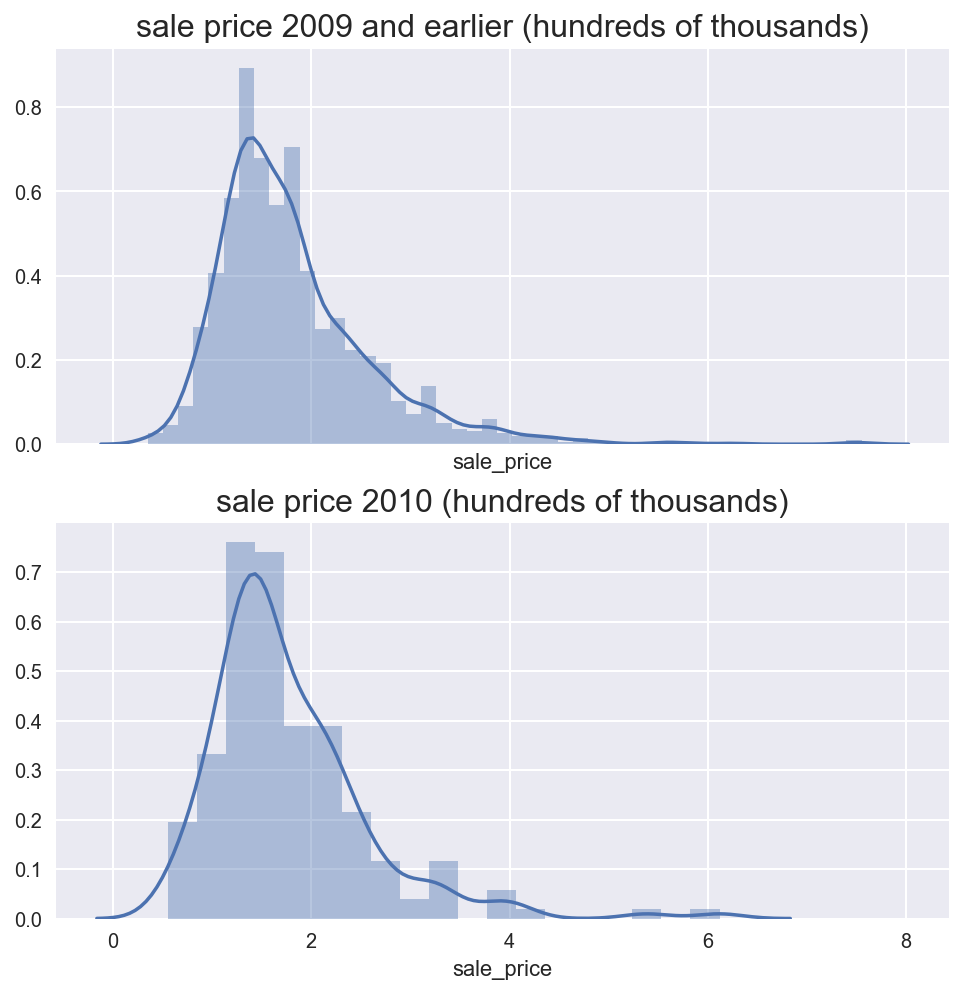

In [4]:
fig, ax = plt.subplots(2,1, figsize = (8,8), sharex = True)

sns.distplot(df[df['yr_sold'] != 2010]['sale_price']/100000, ax = ax[0])
ax[0].set_title('sale price 2009 and earlier (hundreds of thousands)', fontsize = 16)

sns.distplot(df[df['yr_sold'] == 2010]['sale_price']/100000, ax = ax[1])
ax[1].set_title('sale price 2010 (hundreds of thousands)', fontsize = 16);

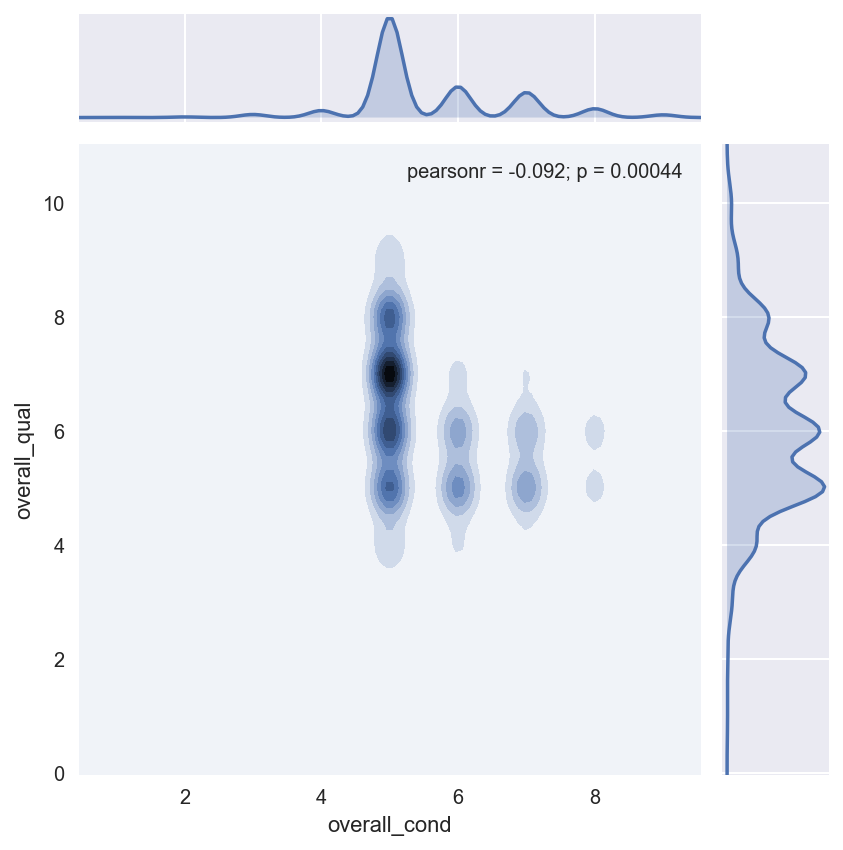

In [5]:
# what about where condition is low but materials (quality) is high
# most houses are condition == 5, and most overall quality houses are in condition == 5
plt.figure(figsize = [8,6])
sns.jointplot(df['overall_cond'], df['overall_qual'], kind = 'kde');

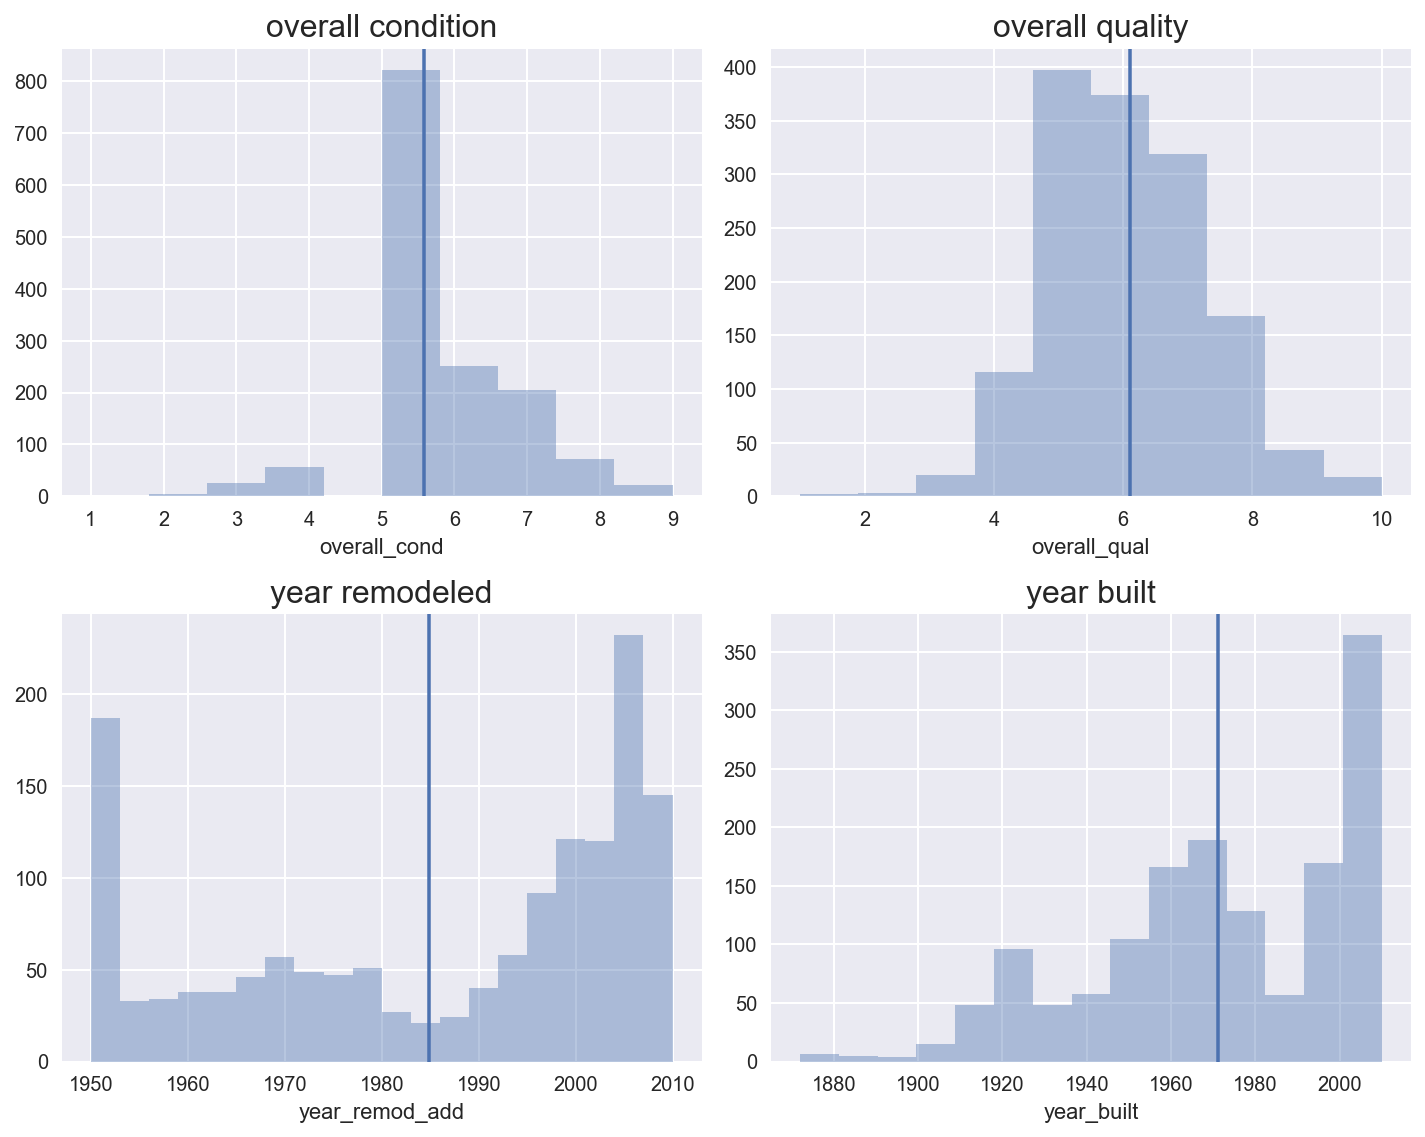

In [6]:
plt.figure(figsize = [10,8])
plt.subplot(2,2,1), sns.distplot(df['overall_cond'], bins = 10, kde = False)
plt.axvline(df['overall_cond'].mean())
plt.title('overall condition', fontsize = 16)

plt.subplot(2,2,2), sns.distplot(df['overall_qual'], bins = 10, kde = False)
plt.axvline(df['overall_qual'].mean())
plt.title('overall quality', fontsize = 16)

plt.subplot(2,2,3), sns.distplot(df['year_remod_add'], bins = 20, kde = False);
plt.axvline(df['year_remod_add'].mean())
plt.title('year remodeled', fontsize = 16)

plt.subplot(2,2,4), sns.distplot(df['year_built'], bins = 15, kde = False);
plt.axvline(df['year_built'].mean())
plt.title('year built', fontsize = 16)


plt.tight_layout();

In [7]:
# no duplicates

num_rows = df.shape[0]
len(df.drop_duplicates()) == num_rows

True

In [8]:
# provide information on the five most frequest values and unique values at the column-level

for col_name, ser in df.iteritems():
    print('column name : {} \nvalue counts: \n{}\nunique values(={}): {}\n'.format(
        col_name,
        ser.value_counts(dropna = False).head(),
        ser.nunique(),
        ser.unique()
    ))

column name : id 
value counts: 
1460    1
479     1
481     1
482     1
483     1
Name: id, dtype: int64
unique values(=1460): [   1    2    3 ..., 1458 1459 1460]

column name : ms_sub_class 
value counts: 
20     536
60     299
50     144
120     87
30      69
Name: ms_sub_class, dtype: int64
unique values(=15): [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]

column name : ms_zoning 
value counts: 
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: ms_zoning, dtype: int64
unique values(=5): ['RL' 'RM' 'C (all)' 'FV' 'RH']

column name : lot_frontage 
value counts: 
NaN      259
 60.0    143
 70.0     70
 80.0     69
 50.0     57
Name: lot_frontage, dtype: int64
unique values(=110): [  65.   80.   68.   60.   84.   85.   75.   nan   51.   50.   70.   91.
   72.   66.  101.   57.   44.  110.   98.   47.  108.  112.   74.  115.
   61.   48.   33.   52.  100.   24.   89.   63.   76.   81.   95.   69.
   21.   32.   78.  121.  122.   40. 

In [9]:
# split level? split foyer?
# 1.5 levels don't have second floor?
df[df['2nd_flr_sf'] == 0]['house_style'].value_counts()

1Story    724
SLvl       47
SFoyer     36
1.5Unf     14
1.5Fin      8
Name: house_style, dtype: int64

In [10]:
# overlap between 1.5 levels and 2nd floor sqft? looks like no. 
df[df['2nd_flr_sf'] != 0]['house_style'].value_counts()

2Story    445
1.5Fin    146
SLvl       18
2.5Unf     11
2.5Fin      8
1Story      2
SFoyer      1
Name: house_style, dtype: int64

### Feature Engineering

In [11]:
# remove commercial zoning entries
df = df[df['ms_zoning'] != 'C (all)']

# add column for houses that haven't been remodedeled
df['remod'] = (df['year_built'] != df['year_remod_add']).astype(int)

# add column for years since remodeled
df['years_since_remod'] = df['year_remod_add'] - df['year_built']

# add column for square feet of finished basement area
df['bsmt_fin_sf'] = df['total_bsmt_sf'] - df['bsmt_unf_sf']

# add column for if a house has basement exposure, since basement exposure column is initially a renovatable feature
df['bsmt_exposure_binary'] = df['bsmt_exposure'].apply(lambda x: 1 if x in ['Av', 'Gd', 'Mn'] else 0)

In [12]:
# consider interaction between bsmt columns. type, square feet finished / unfinished, 
# 2nd floor square feet == 0 --> no second floor?
# non bsmt baths are regular baths. add total bath columns?
# avg sqft per room for house and basement? total sqft?

In [13]:
temp_df = df[['1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'low_qual_fin_sf', 'house_style']].copy()
temp_df['sum'] = temp_df['1st_flr_sf'] + temp_df['2nd_flr_sf'] + temp_df['low_qual_fin_sf']
temp_df['check'] = temp_df['sum'] - temp_df['gr_liv_area']

In [14]:
# any difference between 1st and 2nd floor sqft, and above grade living area is due to low quality finish sqft
print(temp_df[temp_df['check'] != 0].shape)
print(temp_df[temp_df['check'] == 0].shape)

temp_df[temp_df['check'] == 0].head()

(0, 7)
(1450, 7)


,1st_flr_sf,2nd_flr_sf,gr_liv_area,low_qual_fin_sf,house_style,sum,check
0,856,854,1710,0,2Story,1710,0
1,1262,0,1262,0,1Story,1262,0
2,920,866,1786,0,2Story,1786,0
3,961,756,1717,0,2Story,1717,0
4,1145,1053,2198,0,2Story,2198,0


In [15]:
temp_df[temp_df['2nd_flr_sf'] != 0]['house_style'].value_counts()

2Story    444
1.5Fin    143
SLvl       18
2.5Unf     10
2.5Fin      8
1Story      2
SFoyer      1
Name: house_style, dtype: int64

Split houses are best when built on hills. However, the data shows that split housing doesn't appear to significantly interact with anything related to hills compared to the standard housing's interaction with 'hill' features

In [16]:
del temp_df

df[(df['land_contour'] == 'Bnk') | (df['land_contour'] == 'HLS')]['house_style'].value_counts()

1Story    49
2Story    31
1.5Fin    19
2.5Fin     4
1.5Unf     3
2.5Unf     3
SFoyer     1
SLvl       1
Name: house_style, dtype: int64

In [17]:
print(df['lot_shape'].value_counts())
print('\nSplit housing doesn\'t appear to interact with lot_shape either.')
print(df[df['house_style'].isin(['SFoyer', 'SLvl'])]['lot_shape'].value_counts())

Reg    916
IR1    483
IR2     41
IR3     10
Name: lot_shape, dtype: int64

Split housing doesn't appear to interact with lot_shape either.
Reg    60
IR1    42
Name: lot_shape, dtype: int64


Split housing doesn't appear useful, and most closely resemebles '1Story' Housing.

In [18]:
# masking split housing to 1Story
df.loc[df['house_style'].isin(['SFoyer', 'SLvl']), 'house_style'] = '1Story'
# masking 1Story with no 2nd floor sqft to 1Story
df.loc[(df['2nd_flr_sf'] == 0) & (df['house_style'] == '1Story'), 'house_style'] = '1Story'

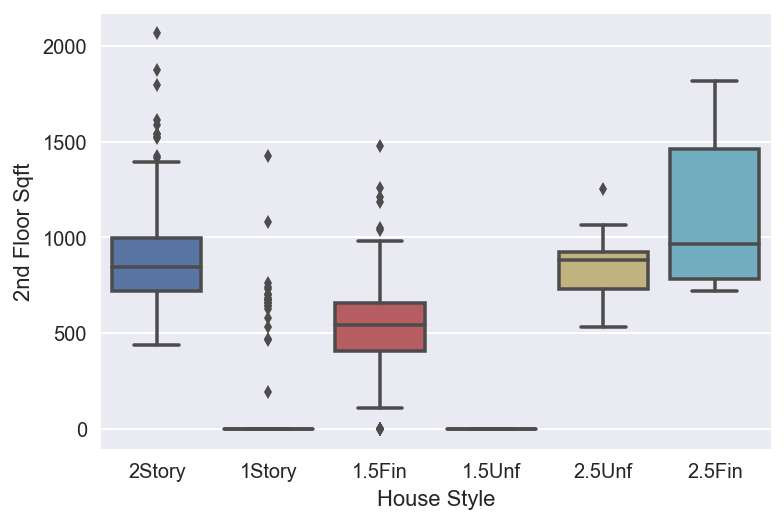

In [19]:
sns.boxplot(df['house_style'], df['2nd_flr_sf'])
plt.xlabel('House Style')
plt.ylabel('2nd Floor Sqft');

In [20]:
# most 1.5s and 2.5s are finished. I think it makes sense to collapse the 1.5s into either 1Story or 2Story
df[df['house_style'].isin(['1.5Fin', '1.5Unf', '2.5Fin', '2.5Unf'])]['house_style'].value_counts()

1.5Fin    150
1.5Unf     14
2.5Unf     10
2.5Fin      8
Name: house_style, dtype: int64

In [21]:
df[(df['house_style'].isin(['2Story', '2.5Fin', '1.5Fin'])) & (df['2nd_flr_sf'] == 0)]['house_style'].value_counts()

1.5Fin    7
Name: house_style, dtype: int64

In [22]:
# masking any 2nd floor sqft == 0 as 1Story
df.loc[df['2nd_flr_sf'] == 0, 'house_style'] = '1Story'

In [23]:
df[df['2nd_flr_sf'] > 0]['2nd_flr_sf'].describe()

count     626.000000
mean      804.667732
std       272.748596
min       110.000000
25%       626.500000
50%       778.500000
75%       927.250000
max      2065.000000
Name: 2nd_flr_sf, dtype: float64

In [24]:
# masking any house style with less than 778.5 2nd floor sqft (median) as 1Story
df.loc[(df['2nd_flr_sf'] < 778.5) & (df['house_style'].isin(['1Story', '1.5Fin', '1.5Unf'])), 'house_style'] = '1Story'

# masking any remaining house style with 2nd floor sqft as 2Story
df.loc[df['2nd_flr_sf'] > 0, 'house_style'] = '2Story'

In [25]:
# kitchen abv grade only has 1 below grade, and is essentially a count of kitchens

estmtrs_no_renovs = [
'sale_price','yr_sold','ms_zoning','lot_frontage','lot_area', 'lot_shape', 'land_contour',
'lot_config','neighborhood','condition1','bldg_type','house_style','roof_style',
'mas_vnr_area','foundation','bsmt_qual','bsmt_exposure_binary','total_bsmt_sf', 
'1st_flr_sf','2nd_flr_sf','bsmt_full_bath','bsmt_half_bath', 'bedroom_abv_gr', 'gr_liv_area','kitchen_abv_gr','fireplaces', 
'functional', 'garage_type','garage_cars','garage_area', 'paved_drive',
'wood_deck_sf','open_porch_sf','enclosed_porch','3_ssn_porch','screen_porch','pool_area','misc_feature',
'misc_val']

df_nr = df[estmtrs_no_renovs].copy()

In [26]:
# selects columns to be dummied
dummy_cols = []
for name, ser in df_nr.iteritems():
    if ser.dtype == 'O':
        dummy_cols.append(name)

# creates dummies
dummy_frame = pd.get_dummies(df_nr[dummy_cols], drop_first = True)

# drops original columns that created dummies
df_nr.drop(dummy_cols, axis = 1, inplace = True)

# recombining dataframe and dummy columns
df_nr = pd.concat([df_nr, dummy_frame], axis = 1)

# filling nan values as zero since they belong to area features after everything has run.
df_nr.fillna(value = 0, inplace = True)

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
X = df_nr.drop('sale_price', axis = 1)
y = df_nr['sale_price']

train_idx = X[X['yr_sold'] != 2010].index
test_idx = X[X['yr_sold'] == 2010].index

X_train = X.loc[train_idx].drop('yr_sold', axis = 1).copy()
X_test = X.loc[test_idx].drop('yr_sold', axis = 1).copy()

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

y_train = y.loc[train_idx].copy()
y_test = y.loc[test_idx].copy()

In [29]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.linear_model import RidgeCV, LassoCV

In [30]:
regs = {'rdg':RidgeCV(), 
        'rdg_bag':BaggingRegressor(RidgeCV(), random_state=101), 
        'las':LassoCV(), 
        'las_bag':BaggingRegressor(LassoCV(), random_state=101), 
        'gbr':GradientBoostingRegressor(random_state=101),
        'gbr_bag':BaggingRegressor(GradientBoostingRegressor(random_state=101), random_state=101),
        'adr':AdaBoostRegressor(random_state=101),
        'adr_bag':BaggingRegressor(AdaBoostRegressor(random_state=101), random_state=101),
        'rfr':RandomForestRegressor(random_state=101)}

In [31]:
d = {}
for reg in regs.items():
    reg[1].fit(X_train, y_train)
    d.update({reg[0]:reg[1].score(X_test, y_test)})
    
    reg[1].fit(Xs_train, y_train)
    d.update({reg[0] + '_s':reg[1].score(Xs_test, y_test)})
    
pd.Series(data = d).sort_values(ascending = False)

gbr_bag_s    0.875222
gbr_bag      0.874851
rdg_bag      0.873080
gbr_s        0.872651
gbr          0.872651
las_bag_s    0.870613
rdg_bag_s    0.870258
rdg          0.860683
las_s        0.860516
rdg_s        0.858704
rfr          0.826568
rfr_s        0.826484
adr_bag_s    0.795993
adr_bag      0.793907
adr          0.786520
adr_s        0.780611
las_bag      0.747303
las          0.734051
dtype: float64

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [32]:
reg = BaggingRegressor(GradientBoostingRegressor(random_state=101), random_state=101)
reg.fit(Xs_train, y_train)

# predictions
yhat_train = reg.predict(Xs_train) 
yhat_test = reg.predict(Xs_test)

# residuals
e_train = y_train - yhat_train
e_test = y_test - yhat_test

In [33]:
# creating new column for residuals
df['error'] = 0

# masking residuals to original DataFrame
df.loc[X_train.index, 'error'] = e_train
df.loc[X_test.index, 'error'] = e_test

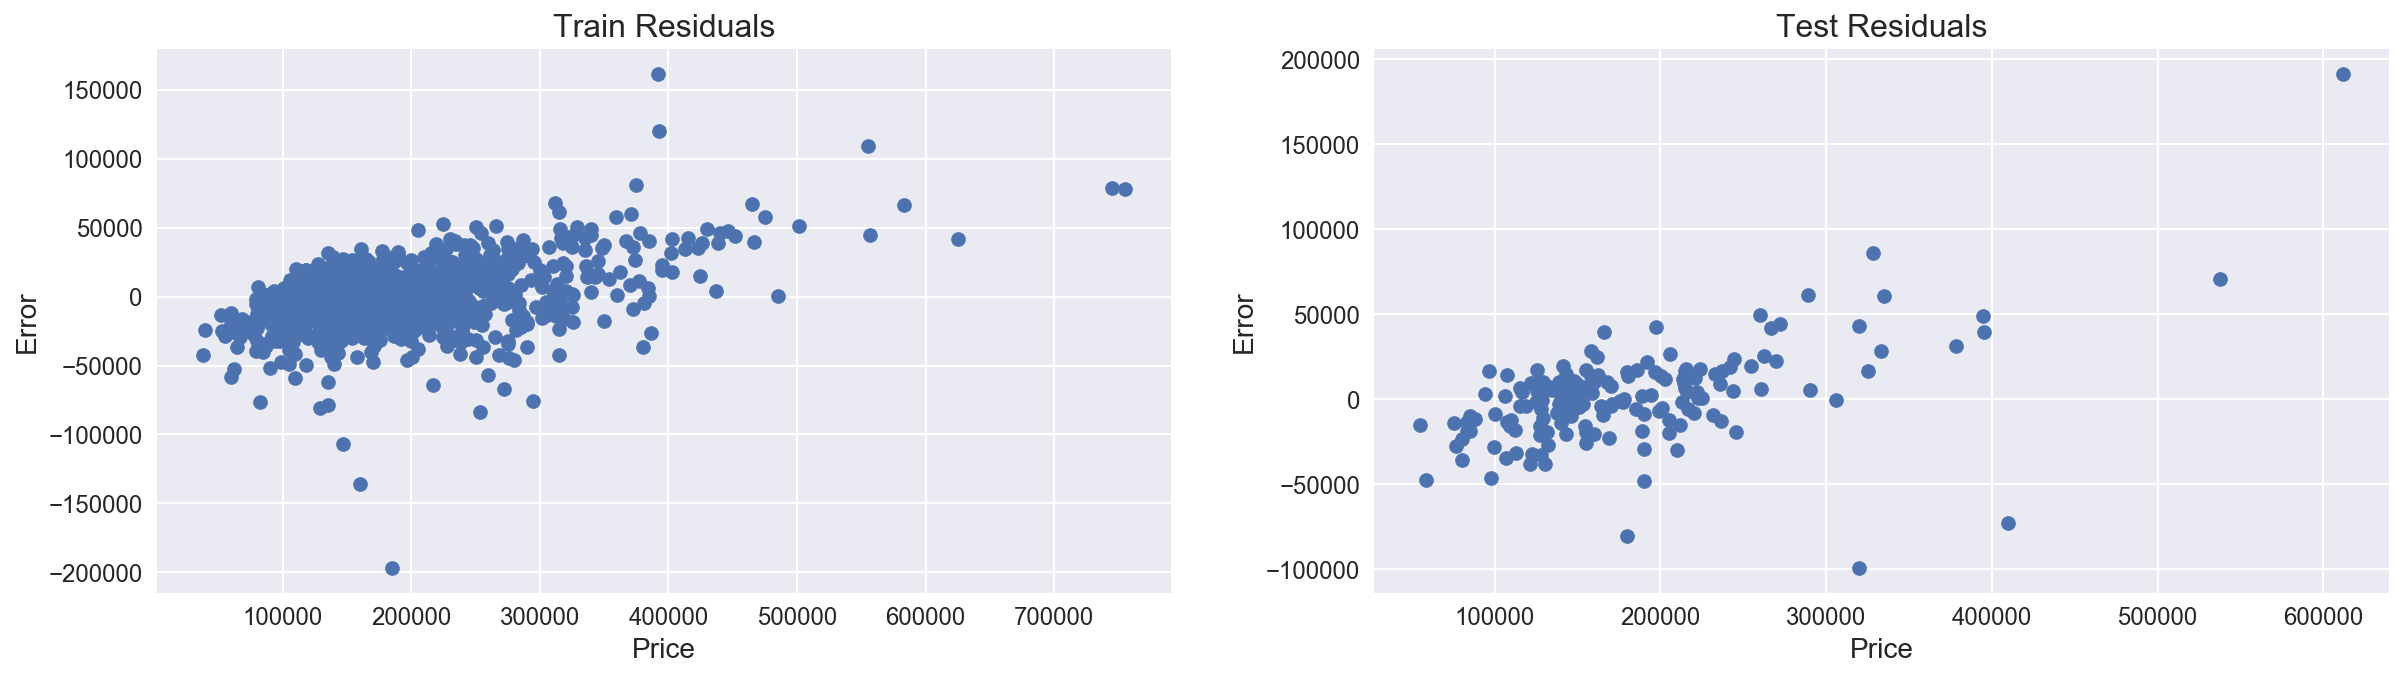

In [34]:
plt.figure(figsize = [20,5])

# e_train, e_test are the residual values

plt.subplot(1,2,1), plt.scatter(y_train, e_train)
plt.title('Train Residuals', fontsize = 16)
plt.xlabel('Price', fontsize = 14)
plt.ylabel('Error', fontsize = 14)
plt.tick_params(labelsize = 12)

plt.subplot(1,2,2), plt.scatter(y_test, e_test)
plt.title('Test Residuals', fontsize = 16)
plt.xlabel('Price', fontsize = 14)
plt.ylabel('Error', fontsize = 14)
plt.tick_params(labelsize = 12)

plt.tight_layout;
# plt.savefig('subplot1.png', dpi = 120, bbox_inches='tight')

In [35]:
renov_cols = [
'error', 'yr_sold', 'roof_matl', 'overall_qual', 'overall_cond',
'exter_cond', 'exter_qual', 'bsmt_cond', 'bsmt_fin_type1', 'bsmt_fin_type2', 'heating_qc', 
'electrical', 'full_bath', 'half_bath', 'kitchen_qual', 'tot_rms_abv_grd',
'fireplace_qu', 'garage_finish', 'garage_qual', 'garage_cond', 'pool_qc', 'fence', 'years_since_remod', 'exterior1st',
'exterior2nd','mas_vnr_type','heating', 'central_air', 'bsmt_fin_sf', 'bsmt_unf_sf']

df_r = df[renov_cols].copy()

In [36]:
# selects columns to be dummied
dummy_cols = []
for name, ser in df_r.iteritems():
    if ser.dtype == 'O':
        dummy_cols.append(name)

# creates dummies
dummy_frame = pd.get_dummies(df_r[dummy_cols], drop_first = True)

# drops original columns that created dummies
df_r.drop(dummy_cols, axis = 1, inplace = True)

# recombining dataframe and dummy columns
df_r = pd.concat([df_r, dummy_frame], axis = 1)

# filling nan values as zero since they belong to area features after everything has run.
df_r.fillna(value = 0, inplace = True)

In [37]:
X = df_r.drop('error', axis = 1)
y = df_r['error']

train_idx = X[X['yr_sold'] != 2010].index
test_idx = X[X['yr_sold'] == 2010].index

X_train = X.loc[train_idx].drop('yr_sold', axis = 1).copy()
X_test = X.loc[test_idx].drop('yr_sold', axis = 1).copy()

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

y_train = y.loc[train_idx].copy()
y_test = y.loc[test_idx].copy()

In [38]:
d = {}
for reg in regs.items():
    reg[1].fit(X_train, y_train)
    d.update({reg[0]:reg[1].score(X_test, y_test)})
    
    reg[1].fit(Xs_train, y_train)
    d.update({reg[0] + '_s':reg[1].score(Xs_test, y_test)})
    
pd.Series(data = d).sort_values(ascending = False)

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

rdg_bag_s    0.229364
rdg_s        0.220355
rdg_bag      0.212693
rdg          0.197900
las_bag_s    0.194935
gbr_s        0.184229
gbr          0.184229
las_s        0.146450
las_bag      0.118047
las          0.116394
gbr_bag_s    0.011238
gbr_bag      0.011142
adr_bag_s   -0.096580
adr_bag     -0.098396
rfr         -0.114050
rfr_s       -0.115386
adr_s       -0.386867
adr         -0.386867
dtype: float64

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [39]:
df['sale_condition'].value_counts()

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: sale_condition, dtype: int64

In [40]:
# creating target variable by setting Abnorml to 1, and everything else to 0
df['sale_condition'] = df['sale_condition'].apply(lambda x: 1 if x == 'Abnorml' else 0)

In [41]:
df['sale_condition'].value_counts()

0    1354
1      96
Name: sale_condition, dtype: int64

In [42]:
df_c = df.copy()
df_c.reset_index(inplace = True, drop = True)

In [43]:
# select object columns
obj_cols = []
for name, ser in df_c.iteritems():
    if ser.dtype == 'O':
        obj_cols.append(name)

In [44]:
# drop all object columns
df_c.drop(obj_cols, axis = 1, inplace = True)

In [45]:
# filling na values
df_c.fillna(value = 0, inplace = True)

In [46]:
# Initialising X and y
X = df_c.drop('sale_condition', axis = 1).copy()
y = df_c['sale_condition'].values

In [47]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [48]:
classifiers = {'rfc':RandomForestClassifier(random_state=101),
               'abc':AdaBoostClassifier(random_state=101),
               'gbc':GradientBoostingClassifier(random_state=101),
               'lgr':LogisticRegression(random_state=101)}

In [49]:
X = df_c.drop('sale_condition', axis = 1).copy()
y = df_c['sale_condition'].values
# skf = StratifiedKFold(n_splits=2, random_state=101)
# skf.get_n_splits(X, y)

In [50]:
baseline = 1 - np.mean(df['sale_condition'])
baseline

0.9337931034482758

In [51]:
for clf in classifiers.items():
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    clf[1].fit(X_train, y_train)
    test_preds = clf[1].predict(X_test)

    print(clf[0], clf[1].score(X_test, y_test), '\n')

    print(pd.crosstab(y_test, test_preds, rownames = ['actual'], colnames = ['Classifications'], margins = True), '\n')

rfc 0.931106471816 

Classifications    0  1  All
actual                      
0                445  3  448
1                 30  1   31
All              475  4  479 

abc 0.929018789144 

Classifications    0  1  All
actual                      
0                445  3  448
1                 31  0   31
All              476  3  479 

gbc 0.931106471816 

Classifications    0  1  All
actual                      
0                446  2  448
1                 31  0   31
All              477  2  479 

lgr 0.935281837161 

Classifications    0  All
actual                   
0                448  448
1                 31   31
All              479  479 



In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lgr = LogisticRegression()
lgr.fit(X_train, y_train)
lgr_coefs = lgr.coef_[0]

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_coefs = rfc.feature_importances_

In [71]:
results = pd.DataFrame({'feature':X.columns, 'lgr_coef': lgr_coefs, 'rfc_coef': rfc_coefs})

In [72]:
# logistic regression most predictive features of an abnormal sale are related to porch and pool
results.sort_values(by = 'lgr_coef', ascending = False, inplace = True)
results.head(15)

,feature,lgr_coef,rfc_coef
30,enclosed_porch,0.004183,0.018862
31,3_ssn_porch,0.002638,0.003594
32,screen_porch,0.002169,0.007518
33,pool_area,0.002042,0.000000
36,yr_sold,0.000912,0.015002
10,bsmt_fin_sf2,0.000568,0.027937
15,low_qual_fin_sf,0.000451,0.003032
6,year_built,0.000406,0.039481
40,bsmt_fin_sf,0.000275,0.013194
4,overall_qual,0.000252,0.021291


In [70]:
# random forest classifier most predictive features of an abnormal sale
results.sort_values(by = 'rfc_coef', ascending = False, inplace = True)
results.head(15)

,feature,lgr_coef,rfc_coef
3,lot_area,-0.000036,0.075999
0,id,0.000089,0.070012
42,error,-0.000025,0.068656
16,gr_liv_area,0.000219,0.052467
12,total_bsmt_sf,0.000144,0.052264
37,sale_price,-0.000002,0.048859
9,bsmt_fin_sf1,-0.000294,0.046707
11,bsmt_unf_sf,-0.000131,0.045231
25,garage_yr_blt,0.000118,0.043111
13,1st_flr_sf,0.000041,0.041039


In [54]:
# preds = {}
# for i, (train_index, test_index) in enumerate(skf.split(X, y)):
#     for clf in classifiers.items():
        
#         X_train, X_test = X.loc[train_index], X.loc[test_index]
#         y_train, y_test = y[train_index], y[test_index]
        
#         clf[1].fit(X_train, y_train)
#         test_preds = clf[1].predict(X_test)
        
#         print(clf[0], clf[1].score(X_test, y_test), '\n')
       
#         print(pd.crosstab(y_test, test_preds, rownames = ['actual'], colnames = ['Classifications'], margins = True), '\n')